In [1]:
import pybamm
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [2]:
# The theoretical capacity of the cells modelled by Marinescu-type 0D models are given
# by cth = (3 * ne * F * S8 / (ns8 * Ms) + ne * F * S4/ (ns4 * Ms)) / 3600

Ms = 32
n4 = 4
F = 9.649e4
S8_initial = 2.6730
ns8 = 8
S4_initial = 0.0128
ns4 = 4
cth = ((3 * n4 * F * S8_initial / (ns8 * Ms)) + (n4 * F * S4_initial / (ns4 * Ms))) / 3600

print("Theoretical Capacity = %2.2f Ah" %(cth))

Theoretical Capacity = 3.37 Ah


In [3]:
# let us take the theoretical capacity down to the level of the 0.211 Ah battery from Hunt.

# define the initial values in grams of various species
S8_initial_g = 2.6730
S4_initial_g = 0.0128
S2_initial_g = 4.3321e-6
S1_initial_g = 1.6321e-6
Sp_initial_g = 2.7e-06

# the total active material mass
m_s = S8_initial_g + S4_initial_g + S2_initial_g + S1_initial_g + Sp_initial_g

# get the mass fractions of the initial conditions
S8_initial_frac = S8_initial_g/m_s
S4_initial_frac = S4_initial_g/m_s
S2_initial_frac = S2_initial_g/m_s
S1_initial_frac = S1_initial_g/m_s
Sp_initial_frac = Sp_initial_g/m_s

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168

# check that the new cell capacity is same as Hunt's
cth = ((3 * n4 * F * S8_initial_frac*m_s_hunt / (ns8 * Ms)) + (n4 * F * S4_initial_frac*m_s_hunt / (ns4 * Ms))) / 3600
print("Theoretical Capacity = %2.3f Ah" %(cth))

# define the current for later simulations
current = 0.0211*2

# define discharge time in seconds for later simulations
hours = 10/2
time_in_seconds = hours*3600

Theoretical Capacity = 0.211 Ah


In [4]:
S8_initial_hunt = S8_initial_frac*m_s_hunt
S4_initial_hunt = S4_initial_frac*m_s_hunt
S2_initial_hunt = S2_initial_frac*m_s_hunt
S1_initial_hunt = S1_initial_frac*m_s_hunt
Sp_initial_hunt = Sp_initial_frac*m_s_hunt
V_initial_hunt = 2.4
initial_data = [0,0,
        V_initial_hunt, 
        S8_initial_hunt, 
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt]

In [67]:
def ic_grab(data, initial_run = False):
    
    if initial_run:
        V_initial = data[0]
        S8_initial = data[1]
        S4_initial = data[2]
        S2_initial = data[3]
        S1_initial = data[4]
        Sp_initial = data[5]
    else:
        ref = -10
        t, Ah, V, S8, S4, S2, S1, Sp, Tc = data
        V_initial = V[ref]
        S8_initial = S8[ref]
        S4_initial = S4[ref]
        S2_initial = S2[ref]
        S1_initial = S1[ref]
        Sp_initial = Sp[ref]
    initial_data = [V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial]
    return initial_data

In [55]:
def hua_2019_alg_discharge_function_ks(inputs):
    
    data, temp, initial_run = inputs
    
    V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial = ic_grab(data,initial_run)
    current = 2*0.0211 # .2C discharge
    model = pybamm.lithium_sulfur.HuaEtAl2019_alg()
    
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": current, # 2C charge
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S1_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Shuttle rate coefficient during charge [s-1]": 0.0002,
        "Shuttle rate coefficient during discharge [s-1]": 0.00002,
        "Reference Temperature [K]" : 298,
        "Ambient Temperature [K]": temp,
        "Initial Cell Temperature [K]": 298
        }
    )
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10/2
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [time_in_seconds,time_in_seconds-100,time_in_seconds-200,time_in_seconds-300]:
        print("trying time %f" %j)
        try:
            # simulate
            sim.solve(np.linspace(0, j,100000))
            # extract data
            t = sim.solution.t
            Ah = abs(current)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries
            Tc = sim.solution["Cell Temperature [K]"].entries

            data = [t, Ah, V, S8, S4, S2, S1, Sp, Tc]
            return data
            
            break
        except:
            pass

In [62]:
def hua_2019_charge_function_alg(inputs):
    
    data, temp, initial_run = inputs
    V_initial, S8_initial, S4_initial, S2_initial, S1_initial, Sp_initial = ic_grab(data, initial_run)
    
    model = pybamm.lithium_sulfur.HuaEtAl2019_alg()
    
    params = model.default_parameter_values
    params.update(
        {
        "Current function [A]": -0.0211,
        "Initial Condition for S8 ion [g]": S8_initial,
        "Initial Condition for S4 ion [g]": S4_initial,
        "Initial Condition for S2 ion [g]": S2_initial,
        "Initial Condition for S ion [g]": S1_initial,
        "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
        "Initial Condition for Terminal Voltage [V]": V_initial,
        "Shuttle rate coefficient during charge [s-1]": 0.0002,
        "Shuttle rate coefficient during discharge [s-1]": 0.0,
        "Reference Temperature [K]" : 298,
        "Ambient Temperature [K]": temp,
        "Initial Cell Temperature [K]": temp
        }
    )
    # Set up and solve simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=params,
        solver=pybamm.CasadiSolver(
            atol=1e-6, rtol=1e-3, extra_options_setup={"max_step_size": 0.1}
        ),
    )
    hours = 10
    time_in_seconds = hours*3600
    print("Starting temperature %f" %(temp))
    for j in [time_in_seconds,time_in_seconds-100,time_in_seconds-200,time_in_seconds-300]:
        print("trying time %f" %j)
        try:
            # simulate
            sim.solve(np.linspace(0, j,100000))
            # extract data
            t = sim.solution.t
            Ah = abs(-0.0211)*t/3600
            V = sim.solution["Terminal voltage [V]"].entries
            S8 = sim.solution["S8 [g]"].entries
            S4 = sim.solution["S4 [g]"].entries
            S2 = sim.solution["S2 [g]"].entries
            S1 = sim.solution["S [g]"].entries
            Sp = sim.solution["Precipitated Sulfur [g]"].entries
            Tc = sim.solution["Cell Temperature [K]"].entries

            data = [t, Ah, V, S8, S4, S2, S1, Sp, Tc]
            return data
            
            break
        except:
            pass

In [121]:
def cycle(initial_inputs):
    data, temp, cycle_numbers = initial_inputs
    
    # get the initial cycle and collect data
    inputs = (data, temp, True)
    data = hua_2019_alg_discharge_function_ks(inputs)
    
    # store data
    output_dict = {'Discharge 1': data}
    
    # perform first charge cycle and collect data
    inputs = (data, temp, False)
    data = hua_2019_charge_function_alg(inputs)
    
    # store data
    output_dict['Charge 1'] = data
    
    for i in range(0,cycle_numbers-1):
        
        # set up & perform discharge
        inputs = (data, temp, False)
        data = hua_2019_alg_discharge_function_ks(inputs)
        
        # store data
        key = 'Discharge ' + str(i+2)
        output_dict[key] = data
        
        # set up & perform charge 
        inputs = (data, temp, False)
        data = hua_2019_charge_function_alg(inputs)
        
        # store data
        key = 'Charge ' + str(i+2)
        output_dict[key] = data
    
    outputs = (output_dict, temp)
    
    return outputs

In [13]:
# get the initial cycle and collect data
inputs = (initial_data, 20+272, True)
data_old = hua_2019_alg_discharge_function_ks(inputs)

Starting temperature 292.000000
trying time 18000.000000


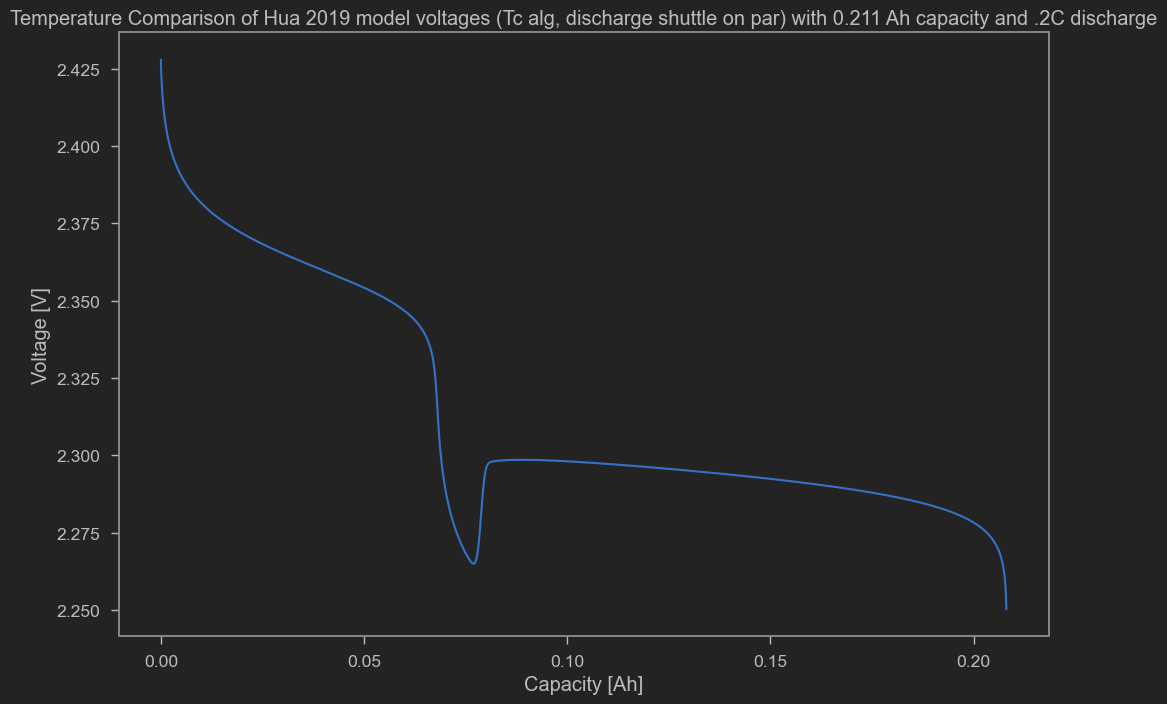

In [15]:
voltage = data_old[2]
Ah = data_old[1]
plt.plot(Ah,voltage)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title("Temperature Comparison of Hua 2019 model voltages (Tc alg, discharge shuttle on par) with 0.211 Ah capacity and .2C discharge")
notify

In [63]:
# perform first charge cycle and collect data
inputs = (data_old, 20+272, False)
data_new = hua_2019_charge_function_alg(inputs)

Starting temperature 292.000000
trying time 36000.000000


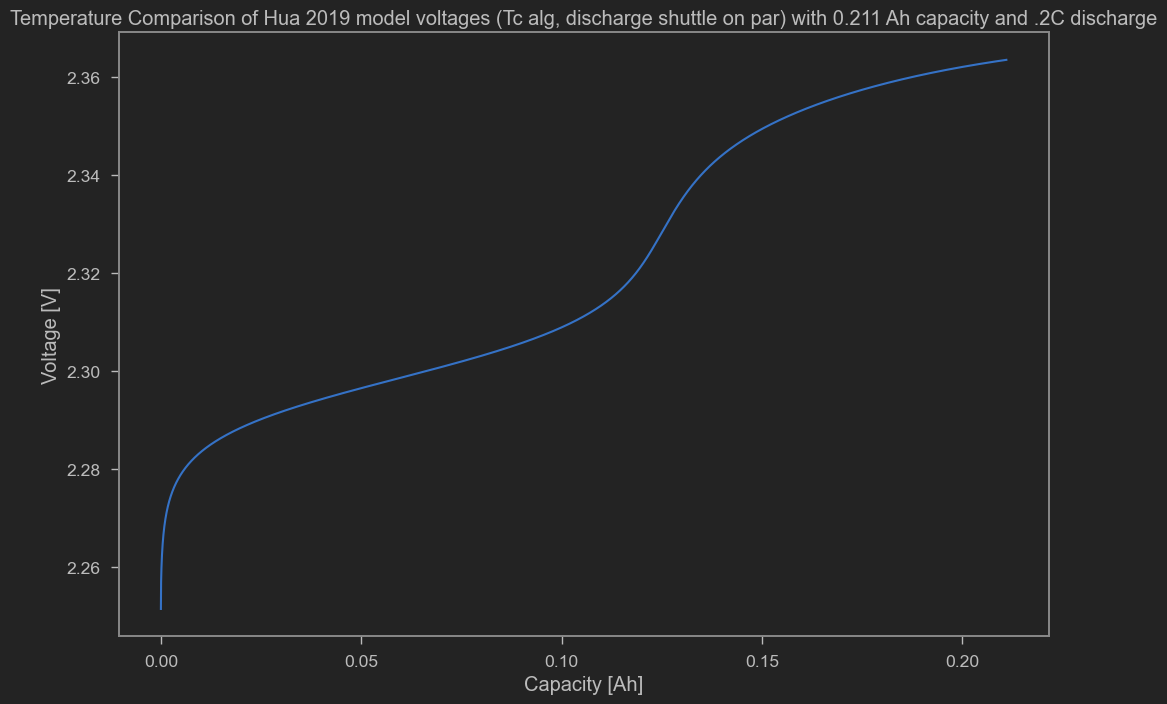

In [64]:
voltage = data_new[2]
Ah = data_new[1]
plt.plot(Ah,voltage)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title("Temperature Comparison of Hua 2019 model voltages (Tc alg, discharge shuttle on par) with 0.211 Ah capacity and .2C discharge")
notify

Starting temperature 292.000000
trying time 18000.000000
Starting temperature 292.000000
trying time 36000.000000
Starting temperature 292.000000
trying time 18000.000000
Starting temperature 292.000000
trying time 36000.000000
Starting temperature 292.000000
trying time 18000.000000
Starting temperature 292.000000
trying time 36000.000000
Starting temperature 302.000000
trying time 18000.000000
Starting temperature 302.000000
trying time 36000.000000
Starting temperature 302.000000
trying time 18000.000000
Starting temperature 302.000000
trying time 36000.000000
Starting temperature 302.000000
trying time 18000.000000
Starting temperature 302.000000
trying time 36000.000000
Starting temperature 312.000000
trying time 18000.000000
Starting temperature 312.000000
trying time 36000.000000
Starting temperature 312.000000
trying time 18000.000000
Starting temperature 312.000000
trying time 36000.000000
Starting temperature 312.000000
trying time 18000.000000
Starting temperature 312.000000

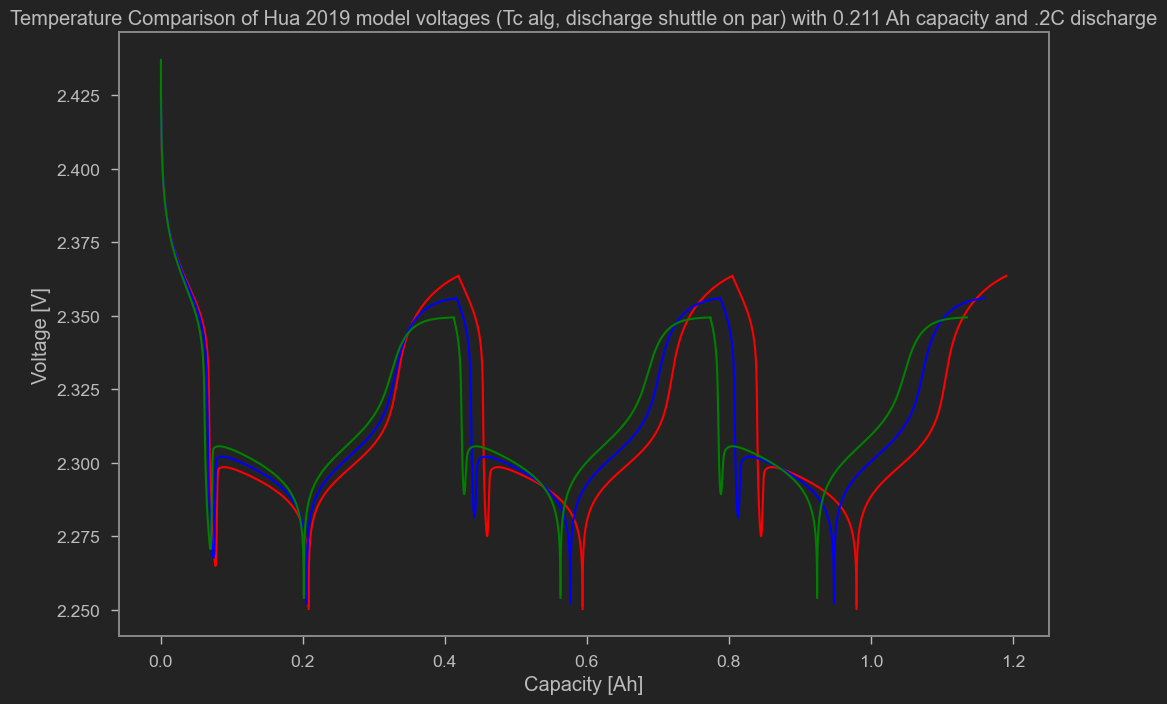

In [124]:
initial_inputs = initial_data, 20+272, 3
outputs30 = cycle(initial_inputs)
output_dict, temp = outputs30
running_capacity = 0
for data in output_dict.values():
    voltage = data[2]
    Ah = data[1] + running_capacity
    plt.plot(Ah,voltage,color='red')
    running_capacity = Ah[-1]

initial_inputs = initial_data, 30+272, 3
outputs30 = cycle(initial_inputs)
output_dict, temp = outputs30
running_capacity = 0
for data in output_dict.values():
    voltage = data[2]
    Ah = data[1] + running_capacity
    plt.plot(Ah,voltage,color='blue')
    running_capacity = Ah[-1]   
    
initial_inputs = initial_data, 40+272, 3
outputs40 = cycle(initial_inputs)
output_dict, temp = outputs40
running_capacity = 0
for data in output_dict.values():
    voltage = data[2]
    Ah = data[1] + running_capacity
    plt.plot(Ah,voltage,color='green')
    running_capacity = Ah[-1]      
    
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title("Temperature Comparison of Hua 2019 model voltages (Tc alg, discharge shuttle on par) with 0.211 Ah capacity and .2C discharge")
notify

In [117]:
output_dict

{'Dicharge 1': [array([0.00000000e+00, 1.80001800e-01, 3.60003600e-01, ...,
         1.77501575e+04, 1.77503375e+04, 1.77503394e+04]),
  array([0.00000000e+00, 2.11002110e-06, 4.22004220e-06, ...,
         2.08071291e-01, 2.08073401e-01, 2.08073422e-01]),
  array([2.42784886, 2.42637202, 2.42628751, ..., 2.25047761, 2.25034623,
         2.25034486]),
  array([1.67198805e-01, 1.67193520e-01, 1.67188100e-01, ...,
         2.74401614e-15, 2.57740682e-15, 2.57572944e-15]),
  array([0.00080065, 0.00080587, 0.00081129, ..., 0.00012194, 0.00011942,
         0.0001194 ]),
  array([2.70977158e-07, 3.05748722e-07, 3.06867842e-07, ...,
         8.39390292e-02, 8.39402889e-02, 8.39403018e-02]),
  array([1.02089476e-07, 1.36874354e-07, 1.38006788e-07, ...,
         1.19039568e-04, 1.19039282e-04, 1.19039279e-04]),
  array([1.68887682e-07, 1.68874368e-07, 1.68861054e-07, ...,
         8.38199896e-02, 8.38212496e-02, 8.38212625e-02]),
  array([292.03921493, 292.03918976, 292.03918711, ..., 292.      

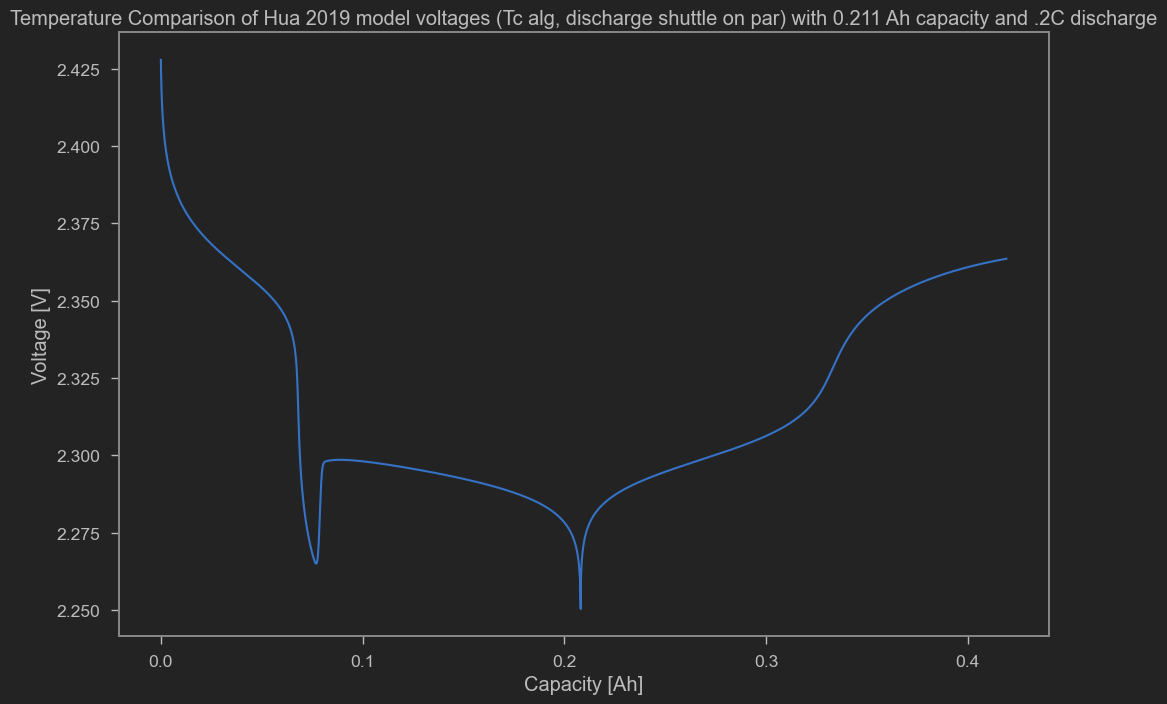

In [104]:
test_data = []
for i in range(0,len(data_old)):
    if i == 1:
        test_data.append(np.concatenate((data_old[i],np.array(data_new[i])+data_old[i][-10])))
    else:
        test_data.append(np.concatenate((data_old[i],data_new[i])))
voltage = test_data[2]
Ah = test_data[1]
plt.plot(Ah,voltage)
plt.xlabel('Capacity [Ah]')
plt.ylabel('Voltage [V]')
plt.title("Temperature Comparison of Hua 2019 model voltages (Tc alg, discharge shuttle on par) with 0.211 Ah capacity and .2C discharge")
notify

In [88]:
i = 1
data_new[i]+data_old[i][-10]

array([0.0000000e+00, 2.1100211e-06, 4.2200422e-06, ..., 2.1099578e-01,
       2.1099789e-01, 2.1100000e-01])

In [101]:
data_old[9]

IndexError: list index out of range